# Example: 

## Decoding the Bayes Optimal prior from the neural activity of a single session

### Setting up

In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import tempfile
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from one.api import ONE
from prior_localization.fit_data import fit_session_ephys

/home/julia/workspace/envs/test/prior/lib/python3.10/site-packages/ibllib/atlas/__init__.py:205: DeprecationWarning: ibllib.atlas is deprecated. Please install iblatlas using "pip install iblatlas" and use this module instead
  warnings.warn('ibllib.atlas is deprecated. Please install iblatlas using "pip install iblatlas" and use '


Instantiate ONE to connect to the public IBL database

In [4]:
one = ONE(base_url='https://openalyx.internationalbrainlab.org', password='international')

Define some settings

In [5]:
# UUID of an example session
session_id = '56956777-dca5-468c-87cb-78150432cc57'

# Get some other required information through the ONE API, like subject nickname and probe names
subject = one.eid2ref(session_id)['subject']
probe_names = one.eid2pid(session_id)[1]

# Create a temporary directory for the outputs (you can replace this with permanent path on your disk)
output_dir = Path(tempfile.TemporaryDirectory().name)

## Run decoding

For an example session, we decode the Bayes Optimal prior from the neural activity. More specifically, we identify the regions along the probe(s) `probe_names`, and perform a region-level decoding.

For each region, we decode from all units the variable `target` (`pLeft` here - so the prior that the stimulus will appear on the left side) from the model `model` (optimal Bayesian here) using Lasso linear regression (see Methods of the paper for more information).

`pseudo_ids` gives the information of whether we decode the session's Bayes optimal prior `pseudo_id=-1`) or whether we decode a counterfactual Bayes optimal prior, from an unobserved pseudo-session (`pseudo_id > 0`). `pseudo_ids=[-1, 1, 2]` indicates that we decode the session's prior as well as counterfactual prior from 2 pseudo-sessions (in the paper, we actually decode priors from 200
pseudo-sessions).

Neural activity is defined as the sum of the spikes over a time window (corresponding to the `time_window` argument, here -600 to -100ms) aligned to a particular event (defined by the `align_event` argument, here stimulus onset)

In [6]:
results_fit_session = fit_session_ephys(
    one, session_id, subject, probe_names, output_dir=output_dir, pseudo_ids=[-1, 1, 2], target='pLeft',
    align_event='stimOn_times', time_window=(-0.6, -0.1), model='optBay', n_runs=2
)

CA1 below min units threshold (10) : 6, not decoding
CA3 below min units threshold (10) : 5, not decoding
COAp below min units threshold (10) : 8, not decoding
IA below min units threshold (10) : 9, not decoding
PA below min units threshold (10) : 4, not decoding
SSp-bfd below min units threshold (10) : 1, not decoding
SSp-tr below min units threshold (10) : 3, not decoding
VISa below min units threshold (10) : 1, not decoding


## Explore the results

The function outputs, for each region and for each pseudo_id, the path file of the decoding results.

In [7]:
results_fit_session

[PosixPath('/tmp/tmp_6wxhukt/NYU-11/56956777-dca5-468c-87cb-78150432cc57/BMA_merged_probes_pseudo_ids_-1_2.pkl'),
 PosixPath('/tmp/tmp_6wxhukt/NYU-11/56956777-dca5-468c-87cb-78150432cc57/CEA_merged_probes_pseudo_ids_-1_2.pkl'),
 PosixPath('/tmp/tmp_6wxhukt/NYU-11/56956777-dca5-468c-87cb-78150432cc57/GPe_merged_probes_pseudo_ids_-1_2.pkl'),
 PosixPath('/tmp/tmp_6wxhukt/NYU-11/56956777-dca5-468c-87cb-78150432cc57/LGd_merged_probes_pseudo_ids_-1_2.pkl'),
 PosixPath('/tmp/tmp_6wxhukt/NYU-11/56956777-dca5-468c-87cb-78150432cc57/VPM_merged_probes_pseudo_ids_-1_2.pkl')]

We load the results for the first region

In [8]:
decoding_results = pickle.load(open(results_fit_session[0], 'rb'))

This gets us a dictionary with some metadata items (`eid`, `subject`, `probe`, `region`, `N_units`) as well as the actual results of the decoding (stored under `fit`)

In [9]:
print(f'decoding keys are {decoding_results.keys()}')
print(f'decoding session: {decoding_results["eid"]}, \n'
      f'decoding subject: {decoding_results["subject"]} \n'
      f'decoding region: {decoding_results["region"]} \n'
      f'number of units in region: {decoding_results["N_units"]}')

decoding keys are dict_keys(['fit', 'subject', 'eid', 'probe', 'region', 'N_units', 'cluster_uuids'])
decoding session: 56956777-dca5-468c-87cb-78150432cc57, 
decoding subject: NYU-11 
decoding region: ['BMA'] 
number of units in region: 51


In [10]:
print(f"number of decodings performed: {len(decoding_results['fit'])}")

number of decodings performed: 6


We plot the BayesOptimal prior decoding for the actual session (`pseudo_id=-1`). Note that we ran the cross validation twice, so we have two results per session. We only plot the first run here

In [11]:
predictions = np.asarray([fit['predictions_test'] for fit in decoding_results['fit'] if fit['pseudo_id'] == -1]).squeeze()
target = np.asarray([fit['target'] for fit in decoding_results['fit'] if fit['pseudo_id'] == -1]).squeeze()

Text(0, 0.5, 'pLeft')

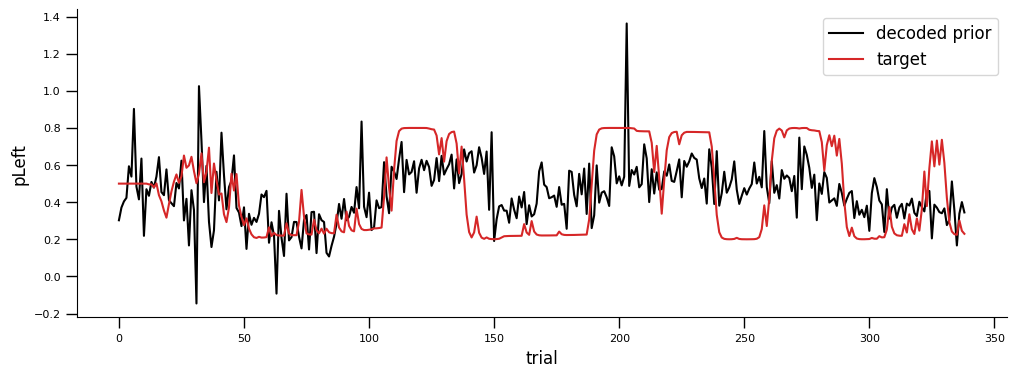

In [12]:
plt.figure(figsize=(12,4))
plt.plot(predictions[0, :], label='decoded prior')
plt.plot(target[0, :], label='target')
plt.legend()
plt.xlabel('trial')
plt.ylabel('pLeft')

Additionally we can compute the Rsquared. `pseudo_Rsquared` are the Rsquared when decoding the counterfactual BayesOpt prior from unobserved pseudosessions. To obtain the "corrected RSquared" that accounts for spurious correlations, we substract the pseudosessions Rsquareds for the sessions Rsquared

In [13]:
pseudo_Rsquared = []
for fit in decoding_results['fit']:
    if fit['pseudo_id'] == -1:
        Rsquared = fit['scores_test_full']
    else:
        pseudo_Rsquared.append(fit['scores_test_full'])

print(f'Uncorrected session Rsquared: {Rsquared}')
print(f'Average pseudosession Rsquared*: {np.mean(pseudo_Rsquared)}')
print(f'Corrected Rsquared: {Rsquared - np.mean(pseudo_Rsquared)}')

print('\n* Only 2 pseudo-sessions are considered in the example, creating large variability in this average. In the paper, we use 200 pseudo-sessions')

Uncorrected session Rsquared: 0.07702507589839336
Average pseudosession Rsquared*: -0.0256440449696769
Corrected Rsquared: 0.10266912086807026

* Only 2 pseudo-sessions are considered in the example, creating large variability in this average. In the paper, we use 200 pseudo-sessions
